# Data Sourcing and Pre-processing for FOMC Prediction Project
In this notebook, we primarily focus on the data sourcing and pre-processing process for the FOMC Prediction Project.

To understand this notebook better, one can refer to the data-procesing paragraph from our paper, which is quoted here for reference:

The data preprocessing pipeline systematically retrieves, cleans, and categorizes text from FOMC meeting PDFs, ensuring consistency across training (1980–2012), validation (2013–2018) and testing (2019-2024) sets. The process iterates over specified years, extracting text page by page and skipping files with errors. Dates are derived from filenames using regex and transforming text into a uniform format. Text cleaning removes headers, numeric lines, parentheses/brackets, and whitespace using regex and stripping. The pipeline then segments text into lines and sentences, categorizing them by speaker (identified via regex) into "Chairman" (prefixed with "CHAIR") and "Other" groups, tracking speakers with a current speaker variable. At the end, all sentences from ‘Chairman’ are concatenated for each document as raw inputs for subsequent modeling efforts.

Finally, PDFs are processed in parallel and the resulting DataFrame is sorted by date and saved as a CSV file. The same pipeline is applied to all sets, differing only in year range to ensure structured data for analysis with efficient execution and error handling.

# Setting Environment

In [ ]:
!pip install pdfplumber --quiet
import os
import re
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize
from datetime import datetime
from multiprocessing import Pool
from tqdm import tqdm
import pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 797.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#IN - check directory list
%cd /content/drive/MyDrive/Datasci-266
%ls

Mounted at /content/drive
/content/drive/MyDrive/Datasci-266
Colab-notebooks-Datasci266/  DS266-final-project/


In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Base directory for FOMC PDFs in Google Drive
# BASE_DIR = '/content/drive/My Drive/266_final/transcript_2020to2024'
BASE_DIR = '/content/drive/MyDrive/Datasci-266/DS266-final-project'
my_drive_path = '/content/drive/MyDrive/'
folder_name = 'Datasci-266/DS266-final-project/'
path_266_final = os.path.join(my_drive_path, folder_name)

# Define Key terms

In [ ]:
KEY_TERMS = {
    "interest_rate": ["interest rate", "funds rate", "yield", "tightening", "easing", "fed funds", "nominal rate", "real rate", "forward guidance", "tapering"],
    "asset_purchasing": ["asset purchasing", "open market operations", "quantitative easing", "bond buying", "buyback program", "repos", "RPs", "reverse RPs", "QE"],
    "gdp": ["GDP", "economic growth", "output growth", "real GDP", "gross domestic product", "economic expansion", "national income", 'real activities'],
    "inflation": ['inflation', 'consumer price', 'price level', 'price', 'PCE', 'CPI','price-level', 'price stability', 'real wage growth'],
    "employment": ['employment','unemployment','labor market']
}

# Cleaning

In [ ]:
def extract_date_from_filename_mod(filename):
    # Match strictly FOMCYYYYMMDDmeeting.pdf format first, then FOMCYYYYMMDDmeeting.pdf format
    match = re.search(r"FOMCpresconf(\d{8})\.pdf", filename, re.IGNORECASE)
    if match:
        date_str = match.group(1)
        return datetime.strptime(date_str, "%Y%m%d").strftime("%Y-%m-%d")
    else:
      match = re.search(r"FOMC(\d{8})meeting\.pdf", filename, re.IGNORECASE)
      if match:
          date_str = match.group(1)
          return datetime.strptime(date_str, "%Y%m%d").strftime("%Y-%m-%d")
    return None

In [ ]:
def clean_text(text):
    text = re.sub(r"(?m)^\s*\d+\s*$", "", text)
    text = re.sub(r"(?m)^\s*Transcript of Federal Open Market Committee Meeting of.*$", "", text)
    text = re.sub(r"\n{2,}", "\n", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"\d+/\s", "", text)
    text = text.strip()
    return text

In [ ]:
def parse_sentences_mod(text):
    lines = text.split("\n")
    chairman_sentences = []
    other_sentences = []
    current_speaker = None
    current_line = ""

    for line in lines:
        speaker_match = re.match(r"^(.*?)\.\s*(.*)$", line)
        if speaker_match:
            if current_speaker and current_line:
                line_sentences = sent_tokenize(current_line.strip())
                if current_speaker.upper().startswith('CHAIR'):
                  chairman_sentences.extend([f"{current_speaker}: {s}" for s in line_sentences])
                else:
                  other_sentences.extend([f"{current_speaker}: {s}" for s in line_sentences])

            current_speaker = speaker_match.group(1)
            current_line = speaker_match.group(2)
        else:
            current_line += " " + line.strip()

    if current_speaker and current_line:
        line_sentences = sent_tokenize(current_line.strip())
        if current_speaker.upper().startswith('CHAIR'):
          chairman_sentences.extend([f"{current_speaker}: {s}" for s in line_sentences])
        else:
          other_sentences.extend([f"{current_speaker}: {s}" for s in line_sentences])

    return {
        'chairman': chairman_sentences,
        'other': other_sentences
    }

In [ ]:
def filter_sentences_mod(sentences, key_terms):
    filtered = {
        "interest_rate": [],
        "asset_purchasing": [],
        "gdp": [],
        'inflation': [],
        'employment': []
    }

    for sentence in sentences:
        sentence_lower = sentence.lower()
        for category, terms in key_terms.items():
            if any(term in sentence_lower for term in terms):
                filtered[category].append(sentence)

    return filtered

In [ ]:
def process_pdf_mod(filepath):
    filename = os.path.basename(filepath)
    date = extract_date_from_filename_mod(filename)
    if not date:
        print(f"Could not extract date from {filename}. Skipping...")
        return None

    try:
        with pdfplumber.open(filepath) as pdf:
            text = ""
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"

        cleaned_text = clean_text(text)
        sentences_dic = parse_sentences_mod(cleaned_text)
        filtered_sentences = filter_sentences_mod(sentences_dic['chairman'], KEY_TERMS)

        return {
            "date": date,
            "interest_rate_sentences": filtered_sentences["interest_rate"],
            "asset_purchasing_sentences": filtered_sentences["asset_purchasing"],
            "gdp_sentences": filtered_sentences["gdp"],
            "inflation_sentences": filtered_sentences["inflation"],
            "employment_sentences": filtered_sentences["employment"],
            'all_chair_sentences': sentences_dic['chairman'],
            'all_other_sentences': sentences_dic['other'],
        }

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

# Execution Train


In [ ]:
%%time
def main():
    my_drive_path = '/content/drive/MyDrive/'
    folder_name = 'Datasci-266/DS266-final-project/'
    path_266_final = os.path.join(my_drive_path, folder_name)
    path_transcript = os.path.join(path_266_final, 'transcript_1980-2024-comb')
    output_file_path = os.path.join(path_266_final, 'fomc_processed_data_train_mod_v2.csv')
    train_years = [1980, 2012] # inclusive

    if not os.path.exists(my_drive_path):
        print(f"My Drive not found at {my_drive_path}. Please ensure Google Drive is mounted.")
        return

    print("Contents of My Drive:", os.listdir(my_drive_path))

    if not os.path.exists(path_266_final):
        print(f"Folder '266_final' not found in My Drive. Available folders:", os.listdir(my_drive_path))
        return
    print("Contents of 266_final:", os.listdir(path_266_final))

    if not os.path.exists(path_transcript):
        print(f"Folder 'transcript_1980-2024-comb' not found in Folder. Available folders:", os.listdir(path_266_final))
        return
    print("Contents of transcript_1980-2024-comb:", os.listdir(path_transcript))

    if not os.path.exists(BASE_DIR):
        print(f"Base directory '{BASE_DIR}' not found in Google Drive. Please verify the path.")
        return

    # Begin here
    all_results = []
    for year in range(train_years[0], train_years[1]+1):
        year_folder = os.path.join(path_transcript, str(year))
        if not os.path.exists(year_folder):
            print(f"Folder '{year_folder}' not found. Skipping...")
            continue

        # List all PDF files in the year folder
        pdf_files = [os.path.join(year_folder, f) for f in os.listdir(year_folder) if f.endswith('.pdf')]
        print(f"Found {len(pdf_files)} PDFs in folder {year}.")

        # Process PDFs in parallel
        with Pool() as pool:
            results = []
            for result in tqdm(pool.imap(process_pdf_mod, pdf_files), total=len(pdf_files), desc=f"Processing {year} PDFs"):
                if result:
                    results.append(result)

        all_results.extend(results)

    if all_results:
        df = pd.DataFrame(all_results)
        df = df[["date", "interest_rate_sentences", "asset_purchasing_sentences", "gdp_sentences", 'inflation_sentences', 'employment_sentences','all_chair_sentences','all_other_sentences']]
        df["date"] = pd.to_datetime(df["date"])
        df.sort_values("date", inplace=True, ignore_index=True)
        output_file = output_file_path
        df.to_csv(output_file, index=False)
        print(f"Processed data saved to {output_file}")
    else:
        print("No data processed.")

if __name__ == "__main__":
    main()

Contents of My Drive: ['ECC-Mongolia Trip-201406', 'Dance related', 'MIT Global Macro Investing Club', 'MIT MBA Study related', 'Misc', 'H1B related', 'PIMCO on-board related', 'PIMCO-Sha (Irene) Na - Supporting documents-second time.rar', 'Plans-20180613.docx', 'LOI Irene NA - Edited.docx', 'SHA NA 11-20-19.pdf', 'CV-Sha (Irene) Na-20220309.pdf', 'Sloan Buffett Trek Photos', '2017 FRP - Wellington', 'CV-Sha (Irene) Na-20220604.pdf', 'Geovera EQ Proposal - Sha.pdf', 'Scan Feb 10, 2024 at 12.44 PM.pdf', 'Scan Feb 10, 2024 at 1.16 PM.pdf', 'Scan Feb 11, 2024 at 12.18 PM.pdf', 'Scan Feb 11, 2024 at 1.54 PM.pdf', 'Scan Feb 14, 2024 at 2.52 PM.pdf', 'Acct No. 067704995576 - Homeowner Transaction History.pdf', 'GMR DocuSign Template 2024.docx.pdf', 'Colab Notebooks', '.ipynb_checkpoints', 'August 2024 Webinar Calendar.pdf', 'Portfolio.gsite', 'Pablo & Sha - Katrina & Patrick.GS.crd1_clean.pdf', 'Datasci-210', 'zoom.ico', 'Datasci-266']
Contents of 266_final: ['transcript_2000-2024', '266_fin

Processing 1980 PDFs: 100%|██████████| 19/19 [02:03<00:00,  6.50s/it]

Found 13 PDFs in folder 1981.



Processing 1981 PDFs: 100%|██████████| 13/13 [01:46<00:00,  8.17s/it]

Found 11 PDFs in folder 1982.



Processing 1982 PDFs: 100%|██████████| 11/11 [01:37<00:00,  8.83s/it]

Found 13 PDFs in folder 1983.



Processing 1983 PDFs: 100%|██████████| 13/13 [01:25<00:00,  6.57s/it]

Found 8 PDFs in folder 1984.



Processing 1984 PDFs: 100%|██████████| 8/8 [01:19<00:00,  9.94s/it]

Found 9 PDFs in folder 1985.



Processing 1985 PDFs: 100%|██████████| 9/9 [01:08<00:00,  7.56s/it]

Found 8 PDFs in folder 1986.



Processing 1986 PDFs: 100%|██████████| 8/8 [01:04<00:00,  8.09s/it]

Found 10 PDFs in folder 1987.



Processing 1987 PDFs: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]

Found 12 PDFs in folder 1988.



Processing 1988 PDFs:   0%|          | 0/12 [00:00<?, ?it/s]

Could not extract date from FOMC19881017confcall.pdf. Skipping...
Could not extract date from FOMC19880105confcall.pdf. Skipping...


Processing 1988 PDFs: 100%|██████████| 12/12 [01:10<00:00,  5.90s/it]

Found 14 PDFs in folder 1989.



Processing 1989 PDFs: 100%|██████████| 14/14 [01:18<00:00,  5.58s/it]

Found 11 PDFs in folder 1990.



Processing 1990 PDFs: 100%|██████████| 11/11 [01:16<00:00,  6.95s/it]

Found 19 PDFs in folder 1991.



Processing 1991 PDFs: 100%|██████████| 19/19 [01:11<00:00,  3.76s/it]

Found 11 PDFs in folder 1992.



Processing 1992 PDFs: 100%|██████████| 11/11 [01:15<00:00,  6.87s/it]

Found 11 PDFs in folder 1993.



Processing 1993 PDFs: 100%|██████████| 11/11 [01:12<00:00,  6.62s/it]

Found 11 PDFs in folder 1994.



Processing 1994 PDFs: 100%|██████████| 11/11 [01:10<00:00,  6.44s/it]

Found 8 PDFs in folder 1995.



Processing 1995 PDFs: 100%|██████████| 8/8 [01:02<00:00,  7.82s/it]

Found 8 PDFs in folder 1996.



Processing 1996 PDFs: 100%|██████████| 8/8 [01:17<00:00,  9.71s/it]


Found 8 PDFs in folder 1997.


Processing 1997 PDFs: 100%|██████████| 8/8 [01:20<00:00, 10.01s/it]

Found 10 PDFs in folder 1998.



Processing 1998 PDFs: 100%|██████████| 10/10 [01:45<00:00, 10.58s/it]

Found 8 PDFs in folder 1999.



Processing 1999 PDFs: 100%|██████████| 8/8 [01:22<00:00, 10.28s/it]

Found 8 PDFs in folder 2000.



Processing 2000 PDFs: 100%|██████████| 8/8 [01:11<00:00,  8.92s/it]

Found 13 PDFs in folder 2001.



Processing 2001 PDFs: 100%|██████████| 13/13 [01:34<00:00,  7.29s/it]

Found 8 PDFs in folder 2002.



Processing 2002 PDFs: 100%|██████████| 8/8 [01:19<00:00,  9.89s/it]


Found 13 PDFs in folder 2003.


Processing 2003 PDFs: 100%|██████████| 13/13 [01:37<00:00,  7.48s/it]

Found 8 PDFs in folder 2004.



Processing 2004 PDFs: 100%|██████████| 8/8 [01:29<00:00, 11.21s/it]

Found 8 PDFs in folder 2005.



Processing 2005 PDFs: 100%|██████████| 8/8 [01:25<00:00, 10.73s/it]

Found 8 PDFs in folder 2006.



Processing 2006 PDFs: 100%|██████████| 8/8 [01:50<00:00, 13.84s/it]

Found 11 PDFs in folder 2007.



Processing 2007 PDFs: 100%|██████████| 11/11 [02:19<00:00, 12.66s/it]

Found 14 PDFs in folder 2008.



Processing 2008 PDFs: 100%|██████████| 14/14 [02:39<00:00, 11.37s/it]

Found 11 PDFs in folder 2009.



Processing 2009 PDFs: 100%|██████████| 11/11 [02:32<00:00, 13.82s/it]


Found 10 PDFs in folder 2010.


Processing 2010 PDFs: 100%|██████████| 10/10 [02:09<00:00, 12.96s/it]

Found 12 PDFs in folder 2011.



Processing 2011 PDFs:   8%|▊         | 1/12 [00:43<07:54, 43.16s/it]

Could not extract date from FOMC20111128confcall.pdf. Skipping...


Processing 2011 PDFs: 100%|██████████| 12/12 [02:45<00:00, 13.77s/it]

Found 13 PDFs in folder 2012.



Processing 2012 PDFs: 100%|██████████| 13/13 [03:21<00:00, 15.46s/it]


Processed data saved to /content/drive/MyDrive/Datasci-266/DS266-final-project/fomc_processed_data_train_mod_v2.csv


# Execution Val

In [ ]:
%%time
def main():
    my_drive_path = '/content/drive/MyDrive/'
    folder_name = 'Datasci-266/DS266-final-project/'
    path_266_final = os.path.join(my_drive_path, folder_name)
    path_transcript = os.path.join(path_266_final, 'transcript_1980-2024-comb')
    output_file_path_val = os.path.join(path_266_final, 'fomc_processed_data_val_mod_v2.csv')
    val_years = [2013, 2018]

    if not os.path.exists(my_drive_path):
        print(f"My Drive not found at {my_drive_path}. Please ensure Google Drive is mounted.")
        return

    print("Contents of My Drive:", os.listdir(my_drive_path))

    if not os.path.exists(path_266_final):
        print(f"Folder '266_final' not found in My Drive. Available folders:", os.listdir(my_drive_path))
        return
    print("Contents of 266_final:", os.listdir(path_266_final))

    if not os.path.exists(path_transcript):
        print(f"Folder 'transcript_1980-2024-comb' not found in Folder. Available folders:", os.listdir(path_266_final))
        return
    print("Contents of transcript_1980-2024-comb:", os.listdir(path_transcript))

    if not os.path.exists(BASE_DIR):
        print(f"Base directory '{BASE_DIR}' not found in Google Drive. Please verify the path.")
        return
   #Begin here
    all_results = []
    for year in range(val_years[0], val_years[1]+1):
        year_folder = os.path.join(path_transcript, str(year))
        if not os.path.exists(year_folder):
            print(f"Folder '{year_folder}' not found. Skipping...")
            continue

        # List all PDF files in the year folder
        pdf_files = [os.path.join(year_folder, f) for f in os.listdir(year_folder) if f.endswith('.pdf')]
        print(f"Found {len(pdf_files)} PDFs in folder {year}.")

        # Process PDFs in parallel
        with Pool() as pool:
            results = []
            for result in tqdm(pool.imap(process_pdf_mod, pdf_files), total=len(pdf_files), desc=f"Processing {year} PDFs"):
                if result:
                    results.append(result)

        all_results.extend(results)

    if all_results:
        df = pd.DataFrame(all_results)
        df = df[["date", "interest_rate_sentences", "asset_purchasing_sentences", "gdp_sentences", 'inflation_sentences', 'employment_sentences','all_chair_sentences','all_other_sentences']]
        df["date"] = pd.to_datetime(df["date"])
        df.sort_values("date", inplace=True, ignore_index=True)
        output_file = output_file_path_val
        df.to_csv(output_file, index=False)
        print(f"Processed data saved to {output_file}")
    else:
        print("No data processed.")

if __name__ == "__main__":
    main()

Contents of My Drive: ['ECC-Mongolia Trip-201406', 'Dance related', 'MIT Global Macro Investing Club', 'MIT MBA Study related', 'Misc', 'H1B related', 'PIMCO on-board related', 'PIMCO-Sha (Irene) Na - Supporting documents-second time.rar', 'Plans-20180613.docx', 'LOI Irene NA - Edited.docx', 'SHA NA 11-20-19.pdf', 'CV-Sha (Irene) Na-20220309.pdf', 'Sloan Buffett Trek Photos', '2017 FRP - Wellington', 'CV-Sha (Irene) Na-20220604.pdf', 'Geovera EQ Proposal - Sha.pdf', 'Scan Feb 10, 2024 at 12.44 PM.pdf', 'Scan Feb 10, 2024 at 1.16 PM.pdf', 'Scan Feb 11, 2024 at 12.18 PM.pdf', 'Scan Feb 11, 2024 at 1.54 PM.pdf', 'Scan Feb 14, 2024 at 2.52 PM.pdf', 'Acct No. 067704995576 - Homeowner Transaction History.pdf', 'GMR DocuSign Template 2024.docx.pdf', 'Colab Notebooks', '.ipynb_checkpoints', 'August 2024 Webinar Calendar.pdf', 'Portfolio.gsite', 'Pablo & Sha - Katrina & Patrick.GS.crd1_clean.pdf', 'Datasci-210', 'zoom.ico', 'Datasci-266']
Contents of 266_final: ['transcript_2000-2024', '266_fin

Processing 2013 PDFs: 100%|██████████| 12/12 [03:12<00:00, 16.06s/it]

Found 13 PDFs in folder 2014.



Processing 2014 PDFs:  23%|██▎       | 3/13 [01:23<04:11, 25.14s/it]

Could not extract date from FOMC20140304confcall.pdf. Skipping...


Processing 2014 PDFs: 100%|██████████| 13/13 [02:48<00:00, 12.96s/it]

Found 12 PDFs in folder 2015.



Processing 2015 PDFs: 100%|██████████| 12/12 [02:59<00:00, 14.97s/it]

Found 12 PDFs in folder 2016.



Processing 2016 PDFs: 100%|██████████| 12/12 [02:39<00:00, 13.30s/it]

Found 12 PDFs in folder 2017.



Processing 2017 PDFs: 100%|██████████| 12/12 [02:08<00:00, 10.72s/it]

Found 12 PDFs in folder 2018.



Processing 2018 PDFs: 100%|██████████| 12/12 [02:21<00:00, 11.76s/it]


Processed data saved to /content/drive/MyDrive/Datasci-266/DS266-final-project/fomc_processed_data_val_mod_v2.csv


# Execution Test

In [ ]:
%%time
def main():
    #IN
    my_drive_path = '/content/drive/MyDrive/'
    folder_name = 'Datasci-266/DS266-final-project/'
    path_266_final = os.path.join(my_drive_path, folder_name)
    path_transcript = os.path.join(path_266_final, 'transcript_1980-2024-comb')
    output_file_path_test = os.path.join(path_266_final, 'fomc_processed_data_test_mod_v2.csv')
    test_years = [2019, 2024]

    # my_drive_path = '/content/drive/My Drive'
    if not os.path.exists(my_drive_path):
        print(f"My Drive not found at {my_drive_path}. Please ensure Google Drive is mounted.")
        return

    print("Contents of My Drive:", os.listdir(my_drive_path))

    if not os.path.exists(path_266_final):
        print(f"Folder '266_final' not found in My Drive. Available folders:", os.listdir(my_drive_path))
        return
    print("Contents of 266_final:", os.listdir(path_266_final))

    if not os.path.exists(path_transcript):
        print(f"Folder 'transcript_1980-2024-comb' not found in Folder. Available folders:", os.listdir(path_266_final))
        return
    print("Contents of transcript_1980-2024-comb:", os.listdir(path_transcript))

    if not os.path.exists(BASE_DIR):
        print(f"Base directory '{BASE_DIR}' not found in Google Drive. Please verify the path.")
        return

    #Begin here
    all_results = []
    for year in range(test_years[0], test_years[1]+1):
        year_folder = os.path.join(path_transcript, str(year))
        if not os.path.exists(year_folder):
            print(f"Folder '{year_folder}' not found. Skipping...")
            continue

        pdf_files = [os.path.join(year_folder, f) for f in os.listdir(year_folder) if f.endswith('.pdf')]
        print(f"Found {len(pdf_files)} PDFs in folder {year}.")

        # Process PDFs in parallel
        with Pool() as pool:
            results = []
            for result in tqdm(pool.imap(process_pdf_mod, pdf_files), total=len(pdf_files), desc=f"Processing {year} PDFs"):
                if result:
                    results.append(result)

        all_results.extend(results)

    if all_results:
        df = pd.DataFrame(all_results)
        df = df[["date", "interest_rate_sentences", "asset_purchasing_sentences", "gdp_sentences", 'inflation_sentences', 'employment_sentences','all_chair_sentences','all_other_sentences']]
        df["date"] = pd.to_datetime(df["date"])
        df.sort_values("date", inplace=True, ignore_index=True)
        output_file = output_file_path_test
        df.to_csv(output_file, index=False)
        print(f"Processed data saved to {output_file}")
    else:
        print("No data processed.")

if __name__ == "__main__":
    main()

Contents of My Drive: ['ECC-Mongolia Trip-201406', 'Dance related', 'MIT Global Macro Investing Club', 'MIT MBA Study related', 'Misc', 'H1B related', 'PIMCO on-board related', 'PIMCO-Sha (Irene) Na - Supporting documents-second time.rar', 'Plans-20180613.docx', 'LOI Irene NA - Edited.docx', 'SHA NA 11-20-19.pdf', 'CV-Sha (Irene) Na-20220309.pdf', 'Sloan Buffett Trek Photos', '2017 FRP - Wellington', 'CV-Sha (Irene) Na-20220604.pdf', 'Geovera EQ Proposal - Sha.pdf', 'Scan Feb 10, 2024 at 12.44 PM.pdf', 'Scan Feb 10, 2024 at 1.16 PM.pdf', 'Scan Feb 11, 2024 at 12.18 PM.pdf', 'Scan Feb 11, 2024 at 1.54 PM.pdf', 'Scan Feb 14, 2024 at 2.52 PM.pdf', 'Acct No. 067704995576 - Homeowner Transaction History.pdf', 'GMR DocuSign Template 2024.docx.pdf', 'Colab Notebooks', '.ipynb_checkpoints', 'August 2024 Webinar Calendar.pdf', 'Portfolio.gsite', 'Pablo & Sha - Katrina & Patrick.GS.crd1_clean.pdf', 'Datasci-210', 'zoom.ico', 'Datasci-266']
Contents of 266_final: ['transcript_2000-2024', '266_fin

Processing 2019 PDFs:  31%|███▏      | 5/16 [02:21<05:43, 31.19s/it]

Could not extract date from FOMC20191004confcall.pdf. Skipping...


Processing 2019 PDFs: 100%|██████████| 16/16 [03:34<00:00, 13.39s/it]

Found 9 PDFs in folder 2020.



Processing 2020 PDFs: 100%|██████████| 9/9 [00:22<00:00,  2.50s/it]

Found 8 PDFs in folder 2021.



Processing 2021 PDFs: 100%|██████████| 8/8 [00:24<00:00,  3.10s/it]

Found 8 PDFs in folder 2022.



Processing 2022 PDFs: 100%|██████████| 8/8 [00:22<00:00,  2.81s/it]

Found 8 PDFs in folder 2023.



Processing 2023 PDFs: 100%|██████████| 8/8 [00:21<00:00,  2.64s/it]

Found 8 PDFs in folder 2024.



Processing 2024 PDFs: 100%|██████████| 8/8 [00:23<00:00,  2.93s/it]


Processed data saved to /content/drive/MyDrive/Datasci-266/DS266-final-project/fomc_processed_data_test_mod_v2.csv
CPU times: user 1.9 s, sys: 475 ms, total: 2.38 s
Wall time: 5min 29s


# Download Finacial Data (for potential prediction targets)

In [ ]:
!pip install --upgrade yfinance --quiet
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
# set the dates
start_date_fin_data = '1980-01-01'
end_time_fin_data = '2025-01-01'

# Download S&P 500 historical data

sp500_mkt = yf.download('^GSPC', start=start_date_fin_data, end=end_time_fin_data)
sp500_mkt = sp500_mkt.droplevel(1, axis=1)
sp500_mkt.index = pd.to_datetime(sp500_mkt.index) #IN: to make sure it's datetime index

# Calculate daily returns
sp500_mkt['return'] = sp500_mkt['Close'].pct_change()


# Get tsy data
tickers_tsy = {
    "tsy10yr": "^TNX",
    "tsy5yr": "^FVX",
    "tsy2yr": "^IRX"  # Note: ^IRX is for 13-week T-bills, but you can replace it with the appropriate 2-year ticker if available
    # 'tsy2yr': '2YY=F'# '2YY=F' is future based 2yr yield, but it only has short history from yahoo finance
}

# Fetch historical yield data
data = {}
for bond, ticker in tickers_tsy.items():
    data[bond] = yf.download(ticker, start=start_date_fin_data, end=end_time_fin_data).droplevel(1, axis=1)["Close"]

# Combine data into a single DataFrame
yield_data = pd.DataFrame(data)
yield_data.index = pd.to_datetime(yield_data.index)

# Get VIX
vix = yf.download('^VIX', start=start_date_fin_data, end=end_time_fin_data).droplevel(1, axis=1)
vix.index = pd.to_datetime(vix.index)


# Get inflation expectation data
infl_exp_df = pd.read_csv(f'{path_266_final}cleveland_fed_infl_exp-202503.csv')
infl_exp_df = infl_exp_df.rename(columns={'DateTime': 'Date'})
infl_exp_df['Date'] = pd.to_datetime(infl_exp_df['Date'])
infl_exp_df.set_index('Date', inplace=True)
infl_exp_df['infl_exp_diff_mnth'] = infl_exp_df['expected_inflation'].diff()
infl_exp_df['infl_exp_diff_nxtm'] = infl_exp_df['infl_exp_diff_mnth'].shift(-1)
infl_exp_df = infl_exp_df.asfreq('D').ffill().asfreq('B')

# infl_exp_df

# Combine financial data
mkt_daily = pd.concat([sp500_mkt['return'].rename('sp_return'), vix['Close'].rename('vix'), yield_data/100,
                       infl_exp_df['infl_exp_diff_nxtm']/100], axis=1).loc[start_date_fin_data:end_time_fin_data,:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


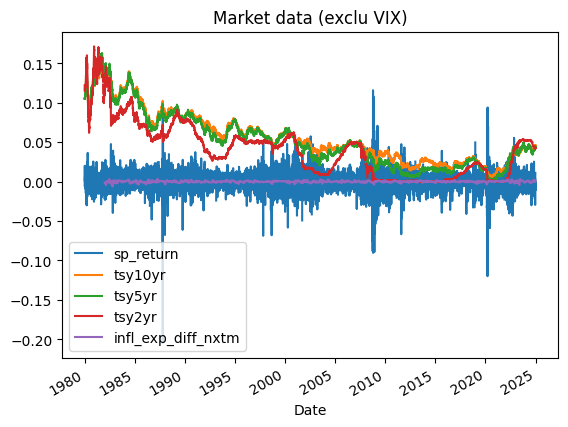

In [ ]:
mkt_daily.drop(columns=['vix']).plot(title='Market data (exclu VIX)')
plt.show()

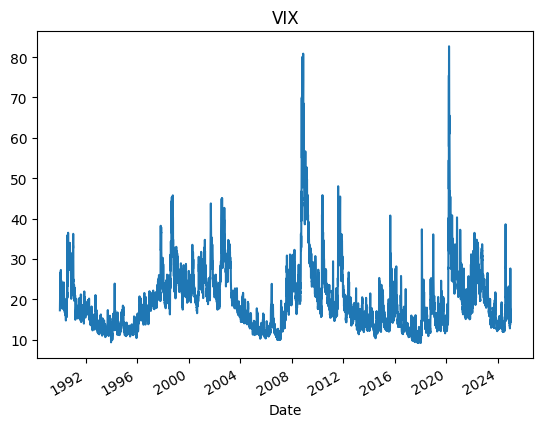

In [ ]:
mkt_daily['vix'].plot(title='VIX')
plt.show()

In [ ]:
# save market data
train_years = [1980, 2012] # inclusive
val_years = [2013, 2018]
test_years = [2019, 2024]

mkt_daily.loc[mkt_daily.index.year<=train_years[1]].to_csv(f'{path_266_final}/mkt_daily_train_v4.csv')
mkt_daily.loc[(mkt_daily.index.year<=val_years[1])&
              (mkt_daily.index.year>=val_years[0])].to_csv(f'{path_266_final}/mkt_daily_val_v4.csv')
mkt_daily.loc[(mkt_daily.index.year<=test_years[1])&
              (mkt_daily.index.year>=test_years[0])].to_csv(f'{path_266_final}/mkt_daily_test_v4.csv')